# RQ5 补充统计

In [1]:
from collections import Counter
import matplotlib.pyplot as plt
import json
import copy

In [34]:
data = []
with open('graph_data_backup/all_pairs_and_usage.txt', 'r', encoding='utf-8') as file:
    file.readline()     # 读掉第一行
    for line in file:
        data.append(eval(line))
data[:5]

[('/api/google-maps', '/api/twitter', 0, 151, 184, 0.82),
 ('/api/twitter', '/api/google-maps', 0, 151, 184, 0.82),
 ('/api/flickr', '/api/youtube', 0, 139, 184, 0.76),
 ('/api/youtube', '/api/flickr', 0, 139, 184, 0.76),
 ('/api/facebook', '/api/twitter', 0, 159, 180, 0.88)]

In [7]:
def remove_symmetry(data):
    # 清理数据，把对称的删除
    data2 = copy.deepcopy(data)
    for d in data2:
        rev_d = (d[1], d[0], d[2], d[3], d[4], d[5])
        if rev_d in data2:
            data2.remove(d)
    return data2

[('/api/twitter', '/api/google-maps', 0, 62, 184, 0.0),
 ('/api/flickr', '/api/youtube', 0, 36, 184, 0.0),
 ('/api/twitter', '/api/facebook', 0, 64, 179, 0.0),
 ('/api/flickr', '/api/google-maps', 0, 46, 171, 0.0),
 ('/api/google-maps', '/api/youtube', 0, 48, 157, 0.0),
 ('/api/twilio-sms', '/api/twilio', 0, 42, 152, 0.0)]

绘图数据准备

In [4]:
gap = 5
act_counter = Counter()
all_counter = Counter()
dea_counter = Counter()
for d in data:
    act = d[3]
    all = d[4]

    level = all - (all % gap)

    act_counter[level] += act
    all_counter[level] += all
    dea_counter[level] += all - act

存活率图像

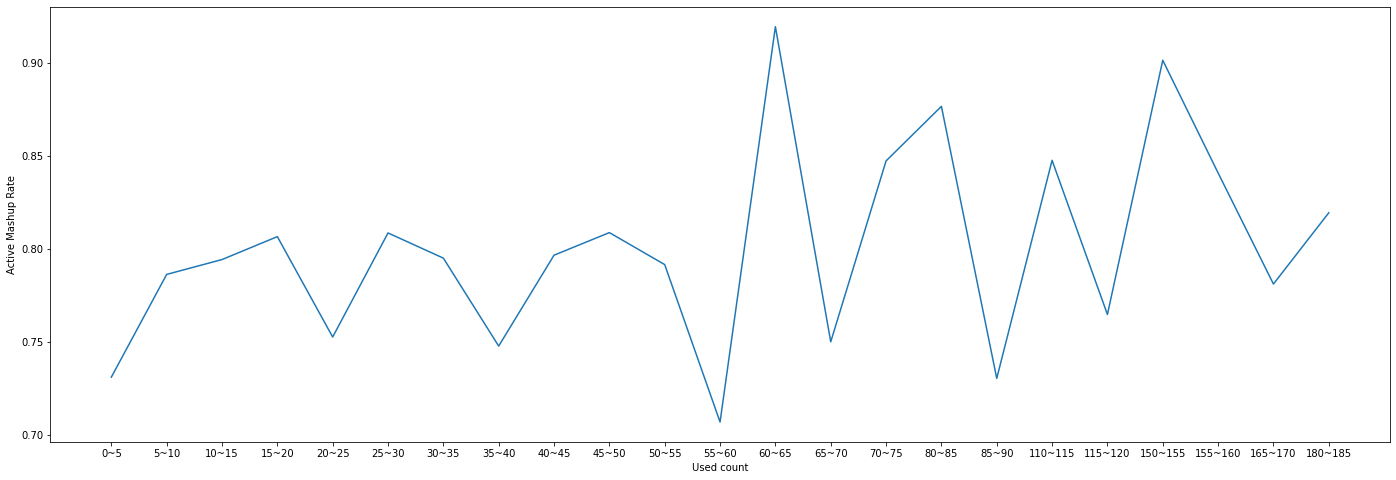

In [5]:
x = [str(k) + '~' + str(k + gap) for k in reversed(list(act_counter.keys()))]    # all_counter 也可
y = [act_counter[k] / all_counter[k] for k in reversed(list(act_counter.keys()))]

plt.figure(figsize=(24, 8))
plt.xlabel('Used count')
plt.ylabel('Active Mashup Rate')
plt.plot(x, y)

死亡率图像

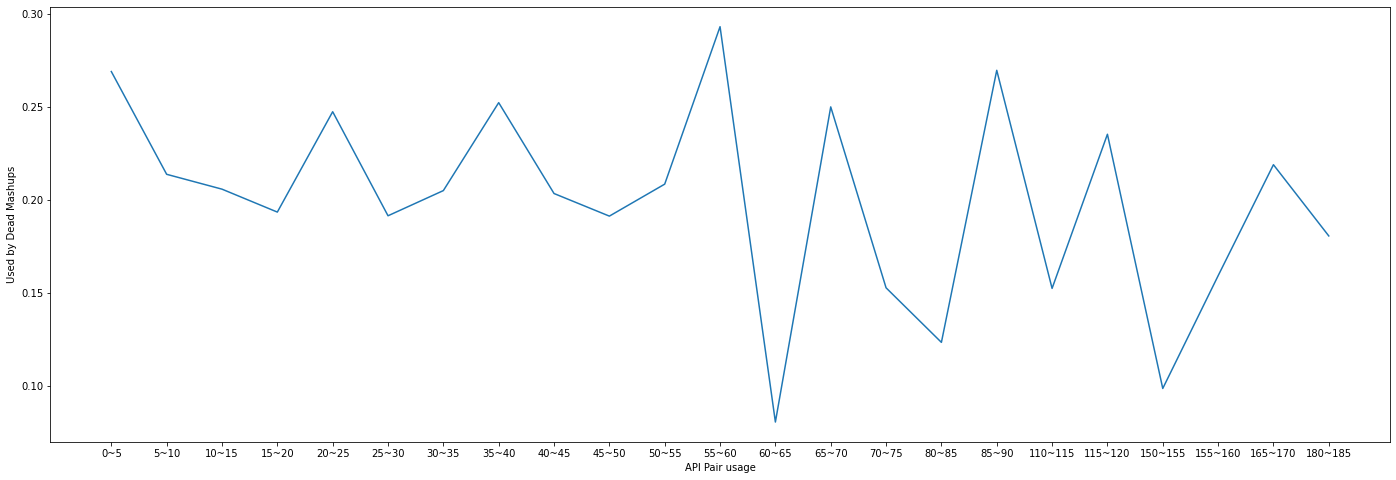

In [35]:
x = [str(k) + '~' + str(k + 5) for k in reversed(list(act_counter.keys()))]    # all_counter 也可
y = [dea_counter[k] / all_counter[k] for k in reversed(list(act_counter.keys()))]

plt.figure(figsize=(24, 8))
plt.xlabel('API Pair usage')
plt.ylabel('Used by Dead Mashups')
plt.plot(x, y)

读取原始数据，然后获取我们实际访问出来的存活情况

In [16]:
with open('graph_data_backup/data0906-1.txt', 'r', encoding='utf-8') as act_file:
    act_mashups = json.load(act_file)
    act_mashups = [m for m in act_mashups if m is not None]

with open('graph_data_backup/deadpool_mashups0917.txt', 'r', encoding='utf-8') as dead_file:
    dead_mashups = json.load(dead_file)
    dead_mashups = [m for m in dead_mashups if m is not None]

all_mashups = act_mashups + dead_mashups

In [17]:
with open('graph_data_backup/mashup_accessibility.txt', 'r') as acc:
    accessibility = json.load(acc)
    # accessibility = [ac for ac in accessibility if ac is not None]
    # build a dict
    acc_dict = {}
    for ac in accessibility:
        if ac is None:
            continue
        else:
            if ac['is_accessible']:
                acc_dict[ac['title']] = True
            else:
                acc_dict[ac['title']] = False

def is_accessible(title):
    return acc_dict.get(title, False)

def produce_pair(apis, requires_reflexive=False, requires_symmetry=False):
    pairs = set()
    sorted_apis = sorted(apis, key=lambda x: x[0])
    for l in sorted_apis:
        if requires_reflexive:
            pairs.add((l, l, 0))
        for r in sorted_apis:
            if l != r:
                if requires_symmetry:
                    pairs.add((l, r, 0))
                else:
                    # 不要对称的
                    if (r, l, 0) not in pairs:
                        pairs.add((l, r, 0))
    return list(pairs)

### 制作一些数据结构方便以后使用

1. mashup_title -> [pair] (list)
2. pair -> [mashup_title]
3. mashup_title -> mashup_object

In [18]:
api_pairs = {}    # mashup和他的pair
api_pair_mashups = {}
mashups_name_dict = {}
for dd in all_mashups:
    mashups_name_dict[dd['title']] = dd
    ra_links = []
    if dd is None:
        continue
    for ra in dd['related_apis']:
        if ra is None:
            continue
        ra_links.append(ra['url'])
    pairs = produce_pair(ra_links, False, True)
    api_pairs[dd['title']] = pairs
    for pair in pairs:
        if pair in api_pair_mashups:
            api_pair_mashups[pair].append(dd['title'])
        else:
            api_pair_mashups[pair] = [dd['title']]

len(api_pairs), len(api_pair_mashups)


(7901, 29078)

In [19]:
api_pairs_counter_all = Counter()
api_pairs_counter_act = Counter()
for mashup_name in api_pairs:
    pairs = api_pairs[mashup_name]
    for pair in pairs:
        api_pairs_counter_all[pair] += 1
        if is_accessible(mashup_name):
            api_pairs_counter_act[pair] += 1

In [20]:
# 整理数据
api_pairs_list = []
for pair in api_pairs_counter_all.keys():
    if pair in api_pairs_counter_act:
        new_pair = (pair[0], pair[1], pair[2], api_pairs_counter_act[pair], api_pairs_counter_all[pair], 0.)
    else:
        # 不在act字典，说明没有被活着的mashup引用
        new_pair = (pair[0], pair[1], pair[2], 0, api_pairs_counter_all[pair], 0.)
    api_pairs_list.append(new_pair)
api_pairs_list = sorted(api_pairs_list, key=lambda x: x[4], reverse=True)
api_pairs_list = remove_symmetry(api_pairs_list)

In [21]:
api_pairs_list[:10]

[('/api/google-maps', '/api/twitter', 0, 62, 184, 0.0),
 ('/api/twitter', '/api/google-maps', 0, 62, 184, 0.0),
 ('/api/flickr', '/api/youtube', 0, 36, 184, 0.0),
 ('/api/youtube', '/api/flickr', 0, 36, 184, 0.0),
 ('/api/facebook', '/api/twitter', 0, 64, 179, 0.0),
 ('/api/twitter', '/api/facebook', 0, 64, 179, 0.0),
 ('/api/flickr', '/api/google-maps', 0, 46, 171, 0.0),
 ('/api/google-maps', '/api/flickr', 0, 46, 171, 0.0),
 ('/api/youtube', '/api/google-maps', 0, 48, 157, 0.0),
 ('/api/google-maps', '/api/youtube', 0, 48, 157, 0.0)]

上面的统计结果没有什么特别的结果

In [36]:
act_count_pair = 0
dead_count_pair = 0
act_count_mashup = 0
dead_count_mashup = 0

for dd in all_mashups:
    ra_links = []
    if dd is None:
        continue
    for ra in dd['related_apis']:
        if ra is None:
            continue
        ra_links.append(ra['url'])
    temp_pairs = produce_pair(ra_links, False, True)
    if is_accessible(dd['title']):
        act_count_mashup += 1
    else:
        dead_count_mashup += 1
    for pair in temp_pairs:
        count = api_pairs_counter_all[pair]
        if is_accessible(dd['title']):
            act_count_pair += count
        else:
            dead_count_pair += count

act_count_pair / float(act_count_mashup), dead_count_pair / float(dead_count_mashup)




(99.856, 112.93739673214614)

## 10.26 统计api的被使用次数，从源文件读入即可

In [8]:
api_usage_counter = Counter()
for ma in all_mashups:
    ras = ma['related_apis']
    for ra in ras:
        if ra is None:
            continue
        api_usage_counter[ra['url']] += 1

len(api_usage_counter)

1693

In [9]:
list(sorted(api_usage_counter.items(), key=lambda x: x[1], reverse=True))[:10]

[('/api/google-maps', 2575),
 ('/api/twitter', 827),
 ('/api/youtube', 710),
 ('/api/flickr', 635),
 ('/api/facebook', 451),
 ('/api/amazon-product-advertising', 433),
 ('/api/twilio', 361),
 ('/api/lastfm', 245),
 ('/api/ebay', 227),
 ('/api/google-search', 194)]

In [10]:
def get_usage(url):
    return api_usage_counter[url]

In [11]:
get_usage('/api/google-maps')

2575

已经有了pair->mashups

还需要mashup->pairs

In [12]:
mashup_count_pairs = {}
for pl in data:
    temp_pair = (pl[0], pl[1], pl[2])
    for mashup in api_pair_mashups[temp_pair]:
        if mashup in mashup_count_pairs:
            mashup_count_pairs[mashup].append(pl)
        else:
            mashup_count_pairs[mashup] = [pl]

list(mashup_count_pairs.items())[:3]


[('Mashup: PropRover',
  [('/api/twitter', '/api/google-maps', 0, 62, 184, 0.0),
   ('/api/feedburner', '/api/twitter', 0, 2, 7, 0.0),
   ('/api/feedburner', '/api/google-maps', 0, 2, 6, 0.0),
   ('/api/feedburner', '/api/facebook-business-mapping', 0, 0, 1, 0.0),
   ('/api/facebook-business-mapping', '/api/twitter', 0, 0, 1, 0.0),
   ('/api/feedburner', '/api/google-my-business', 0, 0, 1, 0.0),
   ('/api/google-my-business', '/api/facebook-business-mapping', 0, 0, 1, 0.0),
   ('/api/google-maps', '/api/facebook-business-mapping', 0, 0, 1, 0.0),
   ('/api/twitter', '/api/google-my-business', 0, 0, 1, 0.0),
   ('/api/facebook-business-mapping', '/api/feedburner', 0, 0, 1, 0.0),
   ('/api/google-maps', '/api/google-my-business', 0, 0, 1, 0.0)]),
 ('Mashup: We Read, We Tweet',
  [('/api/twitter', '/api/google-maps', 0, 62, 184, 0.0),
   ('/api/google-maps', '/api/new-york-times-article-search', 0, 0, 4, 0.0),
   ('/api/twitter', '/api/backtweets', 0, 0, 3, 0.0),
   ('/api/new-york-times-a

In [16]:
is_accessible('Mashup: Best Buys')

False

## 10.30 用于表格的数据
为了制作表格，需要完善一些数据。

但是这些数据涉及到死亡时间，读取mashup的csv文件更直接

In [22]:
import pandas as pd
import numpy as np

with open('graph_data_backup/mashup_nodes_estimator2.csv', 'r', encoding='utf-8') as csvf:
    mashup_nodes = pd.read_csv(csvf, encoding='utf-8', parse_dates=['st', 'et', 'oet'])

# 精简掉
mashup_nodes = mashup_nodes[['name', 'st', 'et', 'oet']]


In [23]:
submit_dead_time_dict = {}

for mashup_name, group in mashup_nodes.groupby('name'):
    dates = (group['st'], group['et'], group['oet'])
    submit_dead_time_dict[mashup_name] = dates

print(len(submit_dead_time_dict))

7766


现在使用submit_dead_time_dict即可获取到三个时间的列表，0~2号元素分别为：[发布时间, 估测死亡时间, pw提供的死亡时间]

但是et和oet都可能是2222年，所以需要多一步判断？

In [10]:
# 试一下如何使用这个时间，然后如何转换为“天”为单位
dates_list = list(submit_dead_time_dict.values())
dates1 = dates_list[0]
st1, oet1 = dates1[0], dates1[2]
print(st1, oet1)
delta1 = oet1 - st1
print(delta1.values[0] / np.timedelta64(1, 'D'))


909   2012-12-20
Name: st, dtype: datetime64[ns] 909   2222-02-22
Name: oet, dtype: datetime64[ns]
76399.0


In [24]:
# 统计一下mashup平均存活时间
# 这里的存活时间是pw的
# 为了方便统计多种情况写一个函数
def get_table_data(api_pairs_list, dead_time='oet'):
    new_pair_list = []
    npday = np.timedelta64(1, 'D')
    for pair in api_pairs_list:
        temp_pair = (pair[0], pair[1], pair[2])
        using_mashup_names = api_pair_mashups[temp_pair]    # 获得了names，要获得详情
        if len(using_mashup_names) == 0:
            print(temp_pair)
            continue
        act_use = 0
        all_use = 0
        alive_days_list = []
        for name in using_mashup_names:
            # mashup_obj = mashups_name_dict[name]
            st, et, oet = submit_dead_time_dict.get(name, (None, None, None))
            # st, et, oet = st.dt.year.values[0], et.dt.year.values[0], oet.dt.year.values[0]
            if st is None:
                # 这个mashup不在csv文件中，直接舍弃
                continue
            # st 不是None，all_use += 1
            all_use += 1
            if dead_time == 'oet':
                # 用oet判断存活与否
                if oet.dt.year.values[0] > 2200:
                    # 活着的mashup
                    act_use += 1
                    # alive_days = '-' # 到目前依然存活
                else:
                    # 已死亡的mashup
                    alive_days = oet - st
                    alive_days_list.append(alive_days.values[0] / npday)
            elif dead_time == 'et':
                # 用et判断存活与否
                if et.dt.year.values[0] > 2200:
                    # 活着的mashup
                    act_use += 1
                else:
                    # 已死亡的mashup
                    alive_days = et - st
                    alive_days_list.append(alive_days.values[0] / npday)
            else:
                print('Use et or oet')
                return None
        if all_use == 0:
            print(temp_pair)
            continue
        dead_use = all_use - act_use
        if dead_use == 0:
            new_pair = (pair[0], pair[1], pair[2], act_use, all_use, act_use / float(all_use), -1)
        else:
            new_pair = (pair[0], pair[1], pair[2], act_use, all_use, act_use / float(all_use), sum(alive_days_list) / dead_use)
        new_pair_list.append(new_pair)

    return new_pair_list

In [25]:
table_data = get_table_data(api_pairs_list, dead_time='et')

('/api/typekey', '/api/paypal', 0)
('/api/paypal', '/api/typekey', 0)
('/api/shoppingcom', '/api/amazon-a9-opensearch', 0)
('/api/amazon-a9-opensearch', '/api/shoppingcom', 0)
('/api/alexa-web-search', '/api/amazon-product-advertising', 0)
('/api/amazon-product-advertising', '/api/alexa-web-search', 0)
('/api/openlayers', '/api/yahoo-maps', 0)
('/api/yahoo-maps', '/api/openlayers', 0)
('/api/openlayers', '/api/microsoft-bing-maps', 0)
('/api/openlayers', '/api/nasa', 0)
('/api/nasa', '/api/openlayers', 0)
('/api/microsoft-bing-maps', '/api/openlayers', 0)
('/api/lyricsfly', '/api/seeqpod', 0)
('/api/lyricsfly', '/api/amazon-simpledb', 0)
('/api/seeqpod', '/api/lyricsfly', 0)
('/api/amazon-simpledb', '/api/lyricsfly', 0)
('/api/smugmug', '/api/google-maps', 0)
('/api/google-maps', '/api/smugmug', 0)
('/api/eventful', '/api/microsoft-mappoint', 0)
('/api/microsoft-mappoint', '/api/eventful', 0)
('/api/delicious-0', '/api/amazon-a9-opensearch', 0)
('/api/amazon-a9-opensearch', '/api/googl

In [29]:
sorted(table_data, key=lambda x: x[4], reverse=True)[:6]

[('/api/google-maps',
  '/api/twitter',
  0,
  63,
  185,
  0.34054054054054056,
  1405.0901639344263),
 ('/api/twitter',
  '/api/google-maps',
  0,
  63,
  185,
  0.34054054054054056,
  1405.0901639344263),
 ('/api/flickr',
  '/api/youtube',
  0,
  36,
  184,
  0.1956521739130435,
  1589.1554054054054),
 ('/api/youtube',
  '/api/flickr',
  0,
  36,
  184,
  0.1956521739130435,
  1589.1554054054054),
 ('/api/facebook',
  '/api/twitter',
  0,
  64,
  179,
  0.3575418994413408,
  1414.2608695652175),
 ('/api/twitter',
  '/api/facebook',
  0,
  64,
  179,
  0.3575418994413408,
  1414.2608695652175)]

In [2]:
# 保存一下
import pickle

In [28]:
# 防止不小心运行就注释掉了，如需导出再取消注释
# table_file = open('table_data et.pkl', 'wb')
# pickle.dump(table_data, table_file)
# table_file.close()


In [3]:
with open('table_data et.pkl', 'rb') as tbf:
    tda = pickle.load(tbf)
sorted(tda, key=lambda x: x[4], reverse=True)[:10]

[('/api/google-maps',
  '/api/twitter',
  0,
  63,
  185,
  0.34054054054054056,
  1405.0901639344263),
 ('/api/twitter',
  '/api/google-maps',
  0,
  63,
  185,
  0.34054054054054056,
  1405.0901639344263),
 ('/api/flickr',
  '/api/youtube',
  0,
  36,
  184,
  0.1956521739130435,
  1589.1554054054054),
 ('/api/youtube',
  '/api/flickr',
  0,
  36,
  184,
  0.1956521739130435,
  1589.1554054054054),
 ('/api/facebook',
  '/api/twitter',
  0,
  64,
  179,
  0.3575418994413408,
  1414.2608695652175),
 ('/api/twitter',
  '/api/facebook',
  0,
  64,
  179,
  0.3575418994413408,
  1414.2608695652175),
 ('/api/flickr',
  '/api/google-maps',
  0,
  47,
  169,
  0.2781065088757396,
  1608.622950819672),
 ('/api/google-maps',
  '/api/flickr',
  0,
  47,
  169,
  0.2781065088757396,
  1608.622950819672),
 ('/api/youtube',
  '/api/google-maps',
  0,
  48,
  157,
  0.3057324840764331,
  1596.5045871559632),
 ('/api/google-maps',
  '/api/youtube',
  0,
  48,
  157,
  0.3057324840764331,
  1596.5045

In [4]:
tda = [(line[0], line[1], line[2], line[3], line[4], round(line[5], 2), round(line[6], 2)) for line in tda]
sorted(tda, key=lambda x: x[4], reverse=True)[:10]

[('/api/google-maps', '/api/twitter', 0, 63, 185, 0.34, 1405.09),
 ('/api/twitter', '/api/google-maps', 0, 63, 185, 0.34, 1405.09),
 ('/api/flickr', '/api/youtube', 0, 36, 184, 0.2, 1589.16),
 ('/api/youtube', '/api/flickr', 0, 36, 184, 0.2, 1589.16),
 ('/api/facebook', '/api/twitter', 0, 64, 179, 0.36, 1414.26),
 ('/api/twitter', '/api/facebook', 0, 64, 179, 0.36, 1414.26),
 ('/api/flickr', '/api/google-maps', 0, 47, 169, 0.28, 1608.62),
 ('/api/google-maps', '/api/flickr', 0, 47, 169, 0.28, 1608.62),
 ('/api/youtube', '/api/google-maps', 0, 48, 157, 0.31, 1596.5),
 ('/api/google-maps', '/api/youtube', 0, 48, 157, 0.31, 1596.5)]

In [5]:
# 去除对称的

data = tda
# data = api_pairs_list
for d in data:
    rev_d = (d[1], d[0], d[2], d[3], d[4], d[5], d[6])
    if rev_d in data:
        data.remove(d)

In [15]:
# 查看这个数据里面有没有存活率特别高的
high_ratio_low_use = sorted([p for p in tda if 10 <= p[4] <= 80 and p[5] >= 0.5], key=lambda x: x[5], reverse=True)

In [33]:
data[:6], [d for d in data if d[4] >= 10][-6:]

([('/api/twitter', '/api/google-maps', 0, 63, 185, 0.34, 1405.09),
  ('/api/youtube', '/api/flickr', 0, 36, 184, 0.2, 1589.16),
  ('/api/twitter', '/api/facebook', 0, 64, 179, 0.36, 1414.26),
  ('/api/google-maps', '/api/flickr', 0, 47, 169, 0.28, 1608.62),
  ('/api/google-maps', '/api/youtube', 0, 48, 157, 0.31, 1596.5),
  ('/api/twilio-sms', '/api/twilio', 0, 43, 153, 0.28, 1259.22)],
 [('/api/yahoo-shopping', '/api/ebay', 0, 2, 10, 0.2, 1121.12),
  ('/api/technorati', '/api/lastfm', 0, 4, 10, 0.4, 1788.17),
  ('/api/delicious-0', '/api/feedburner', 0, 2, 10, 0.2, 1474.25),
  ('/api/yahoo-search', '/api/yahoo-video-search', 0, 2, 10, 0.2, 1947.25),
  ('/api/twitter', '/api/technorati', 0, 2, 10, 0.2, 1139.88),
  ('/api/wikipedia', '/api/geonames', 0, 3, 10, 0.3, 1033.71)])

In [7]:
# 导出前几个为csv文件，方便转换成tex的表格
k = -1
with open('top all et.csv', 'w', encoding='utf-8') as tbcsv:
    tbcsv.write('API1,API2,Active Use,Total Use,Ratio,Avg Days\n')
    for row in tda[:k]:
        tbcsv.write('{},{},{},{},{},{}\n'.format(row[0], row[1], row[3], row[4], row[5], row[6]))